# Import

In [1]:
from model import ChessNet
import torch
import torch.nn as nn
from torchsummary import summary
import pandas as pd
from utils import read_pgn
import chess
from IPython.display import display, clear_output
from time import sleep, time
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import os
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing

In [3]:
df1 = pd.read_csv("../games_metadata_profile.csv")
df2 = pd.read_csv("../games_metadata_profile_2024_01.csv")


def format_game_mode(x):
    if "Classical" in x:
        return "Classical game"
    elif "Bullet" in x:
        return "Bullet game"
    elif "Blitz" in x:
        return "Blitz game"
    elif "UltraBullet" in x:
        return "UltraBullet game"
    elif "Rapid" in x:
        return "Rapid game"
    elif "Correspondence" in x:
        return "Correspondence game"
    else:
        return x


df = pd.concat([df1, df2], ignore_index=True)

df["Mode"] = df["Event"].apply(format_game_mode)

df = df[df["Mode"] == "Blitz game"]

In [4]:
df_elo_below_1450 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 <= 1450]
df_elo_1450_to_1800 = df[
    ((df["WhiteElo"] + df["BlackElo"]) / 2 > 1450)
    & ((df["WhiteElo"] + df["BlackElo"]) / 2 <= 1800)
]
df_elo_above_1800 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 > 1800]

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

del df1, df2, df
gc.collect()

# games with average elo below 1450: (30057, 34)
# games with average elo between 1450 and 1800: (32038, 34)
# games with average elo above 1800: (31863, 34)


0

In [5]:
cutoff = 15000  # number of games to use for each partition

# set fixed seed for reproducibility
random_state = 42

df_elo_below_1450 = df_elo_below_1450.sample(cutoff, random_state=random_state)

df_elo_1450_to_1800 = df_elo_1450_to_1800.sample(cutoff, random_state=random_state)

df_elo_above_1800 = df_elo_above_1800.sample(cutoff, random_state=random_state)

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")
print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")
print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (15000, 34)
# games with average elo between 1450 and 1800: (15000, 34)
# games with average elo above 1800: (15000, 34)


In [6]:
# move ==> (_from, _to, board)
# board ==> 8x8 numpy array
def process_game(moves: List[chess.Move]):
    board = chess.Board()
    samples = []
    for move in moves:
        _from, _to = move.from_square, move.to_square
        parts = board.fen().split(" ")
        board_fen = parts[0]
        turn = parts[1]
        castling_rights = parts[2]
        # from square index to algebraic notation
        piece = board.piece_at(_from)
        _from, _to = chess.SQUARE_NAMES[_from], chess.SQUARE_NAMES[_to]
        samples.append(
            (
                str(_from),
                str(_to),
                str(piece),
                str(turn),
                str(castling_rights),
                board_fen,
            )
        )
        board.push(move)

    return samples

In [7]:
def pgns_to_samples(
    game_pgns: List[str] = None,
    save_dir: str = None,
    suffix: str = "",
    write_to_disk: bool = True,
):
    assert (
        game_pgns is not None or save_dir is not None
    ), "game_pgns OR save_dir must be provided"

    is_train_saved = False
    is_test_saved = False
    train_samples = []
    test_samples = []
    if save_dir:
        if f"train_{suffix}.pkl" in os.listdir(save_dir):
            is_train_saved = True
            with open(f"{save_dir}/train_{suffix}.pkl", "rb") as f:
                train_samples = pickle.load(f)
            print(f"Loading train samples from disk size: {len(train_samples)}")

        if f"test_{suffix}.pkl" in os.listdir(save_dir):
            is_test_saved = True
            with open(f"{save_dir}/test_{suffix}.pkl", "rb") as f:
                test_samples = pickle.load(f)
            print(f"Loading test samples from disk size: {len(test_samples)}")

    if game_pgns is not None:
        train_pgn, test_pgn = train_test_split(
            game_pgns, test_size=0.2, random_state=42
        )

        if not is_train_saved:
            print("Processing train samples")
            for game_pgn in tqdm(train_pgn):
                game_moves = read_pgn(game_pgn)
                train_samples.extend(process_game(game_moves))
            train_samples = list(set(train_samples))
            if write_to_disk:
                with open(f"{save_dir}/train_{suffix}.pkl", "wb") as f:
                    pickle.dump(train_samples, f)
                    print(f"Train samples saved to {save_dir}/train_{suffix}.pkl")

        if not is_test_saved:
            print("Processing test samples")
            for game_pgn in tqdm(test_pgn):
                game_moves = read_pgn(game_pgn)
                test_samples.extend(process_game(game_moves))
            test_samples = list(set(test_samples))
            if write_to_disk:
                with open(f"{save_dir}/test_{suffix}.pkl", "wb") as f:
                    pickle.dump(test_samples, f)
                    print(f"Test samples saved to {save_dir}/test_{suffix}.pkl")
    return train_samples, test_samples

In [8]:
game_below_1450 = df_elo_below_1450["Moves"].values
game_1450_to_1800 = df_elo_1450_to_1800["Moves"].values
game_above_1800 = df_elo_above_1800["Moves"].values

In [9]:
save_dir = "data"
train_below_1450, test_below_1450 = pgns_to_samples(
    save_dir=save_dir,
    suffix="below_1450_15kCUTOFF",
    # write_to_disk=False,
    game_pgns=game_below_1450,
)
train_1450_to_1800, test_1450_to_1800 = pgns_to_samples(
    save_dir=save_dir,
    suffix="1450_to_1800_15kCUTOFF",
    # write_to_disk=False,
    game_pgns=game_1450_to_1800,
)
train_above_1800, test_above_1800 = pgns_to_samples(
    save_dir=save_dir,
    suffix="above_1800_15kCUTOFF",
    # write_to_disk=False,
    game_pgns=game_above_1800,
)

Loading train samples from disk size: 658096
Loading test samples from disk size: 167298
Loading train samples from disk size: 712163
Loading test samples from disk size: 181459
Loading train samples from disk size: 773308
Loading test samples from disk size: 198207


In [10]:
def transform_board(
    board: chess.Board, mask_loc: str = None, add_legal_moves: bool = False
) -> torch.Tensor:
    piece_map = {
        "p": 1,
        "n": 2,
        "b": 3,
        "r": 4,
        "q": 5,
        "k": 6,
        "P": 7,
        "N": 8,
        "B": 9,
        "R": 10,
        "Q": 11,
        "K": 12,
    }
    board_tensor = torch.zeros(12, 8, 8)
    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))
            if piece is not None:
                piece_symbol = piece.symbol()
                board_tensor[piece_map[piece_symbol] - 1, i, j] = 1

    if add_legal_moves:  # add new channels of legal moves to the board tensor
        legal_moves = board.legal_moves
        legal_move_channel = torch.zeros(1, 8, 8)
        for move in legal_moves:
            to_square = move.to_square
            legal_move_channel[0, to_square % 8, to_square // 8] = 1
            # check if the move is a capture
            if board.is_capture(move):
                legal_move_channel[0, to_square % 8, to_square // 8] *= 2
        board_tensor = torch.cat((board_tensor, legal_move_channel), dim=0)

    if mask_loc is not None:  # add new channels of mask to the board tensor
        mask_tensor = torch.zeros(1, 8, 8)
        # convert mask_loc san to square index
        mask_square = chess.parse_square(mask_loc)
        piece = board.piece_at(mask_square)
        if piece is None:
            raise ValueError(f"no piece at mask square {mask_loc}")
        mask_tensor[0, mask_square % 8, mask_square // 8] = 1
        board_tensor = torch.cat((board_tensor, mask_tensor), dim=0)

    return board_tensor

In [11]:
def group_board(samples):
    board_grouped = {}

    # count the number of moves for each piece in each board state
    for sample in samples:
        _from, _to, piece, board_fen = sample
        board_position = board_fen.split(" ")[0]

        if board_position not in board_grouped:

            board_grouped[board_position] = {"total": 0}


        for idx, subkey in enumerate(
            [
                _from
                #   , _to
            ]
        ):
            # if idx == 0: # specicial prefix to denote from or to
            #     subkey = f"f{subkey}"
            # else:
            #     subkey = f"t{subkey}"
            if subkey not in board_grouped[board_position]:
                board_grouped[board_position][subkey] = 0
            board_grouped[board_position][subkey] += 1


        board_grouped[board_position]["total"] += 1

    # convert the count to probability distribution
    for board_position in board_grouped:

        total = board_grouped[board_position]["total"]

        for subkey in board_grouped[board_position]:
            if subkey == "total":
                continue
            board_grouped[board_position][subkey] /= total

        del board_grouped[board_position]["total"]

    # dict to list

    board_grouped = list(board_grouped.items())
    return board_grouped

In [12]:
# transform piece distribution to tensor label
# piece_distribution = {'e1': 0.5, 'd2': 0.2, ...}
# piece_distribution ==> tensor(64)
def piece_distribution_to_label(piece_distribution):
    label = torch.zeros(64)

    for i, piece in enumerate(piece_distribution):
        idx = chess.parse_square(piece)
        label[idx] = piece_distribution[piece]

    return label

In [13]:
def filter_by_piece(samples: List[Tuple[str, str, str, str]], piece: str):
    return list(filter(lambda x: x[2].lower() == piece, samples))

# Dataset

In [14]:
class ChessGroupedDataset(Dataset):
    def __init__(self, grouped_moves: List[Tuple[str, dict]]):
        self.grouped_moves = grouped_moves

    def __len__(self):
        return len(self.grouped_moves)

    def __getitem__(self, idx):
        board_fen, piece_probs = self.grouped_moves[idx]
        board = chess.Board(board_fen)
        # feature is the board tensor
        x = transform_board(board)
        # label is one-hot encoded _from
        y = piece_distribution_to_label(piece_probs)
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

In [15]:
class ChessDataset(Dataset):
    def __init__(
        self,
        moves: List[Tuple[str, str, str, str]],
        mask_move: bool = False,
        add_legal_moves: bool = False,
    ):
        self.moves = moves  # (from, to, piece, turn, castling_rights, board_fen)
        self.mask_move = mask_move
        self.add_legal_moves = add_legal_moves  # encode legal moves into board tensor

    def __len__(self):
        return len(self.moves)

    def __getitem__(self, idx):
        _from, _to, piece, turn, castling_rights, board_fen = self.moves[idx]
        fen = board_fen + " " + turn + " " + castling_rights + " - 0 1"
        board = chess.Board(fen)
        # feature is the board tensor
        x = transform_board(
            board,
            mask_loc=_from if self.mask_move else None,
            add_legal_moves=self.add_legal_moves,
        )
        # label is one-hot encoded _from
        y = torch.zeros(64)
        # convert _to name to index, igoring promotion(last letter)
        _to = chess.parse_square(_to[:2])
        y[_to] = 1
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

# Training

In [16]:
def training(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_loss = []
    start = time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                elapsed = time() - start
                # number of batches per epoch

                print(
                    f"epoch {epoch+1}/{num_epochs} | batch {i+1}/{len(dataloader)} | loss: {running_loss / 100} | elap: {elapsed:.2f}s"
                )
                train_loss.append(running_loss / 100)
                running_loss = 0.0
    return train_loss

In [17]:
# get the move from argmax of the predicted distribution
def argmax_move(batch: torch.Tensor):
    argmax_idx = torch.argmax(batch, dim=1)
    pred_y = torch.zeros_like(batch)
    pred_y[torch.arange(batch.shape[0]), argmax_idx] = 1

    return pred_y.to(device)

# Training piece selection

## Model + training

In [ ]:
model = ChessNet(
    num_classes=64,
    num_channels=6,
    activation=nn.LeakyReLU(inplace=True),
).to(device)

In [ ]:
# load model
# model.load_state_dict(torch.load("piece_grouped_sel_ce_20epc.pth"))

In [ ]:
# summary(model, (6, 8, 8), batch_size=1)

In [ ]:
grouped_train_samples = group_board(train_below_1450)
grouped_test_samples = group_board(test_below_1450)

len(grouped_train_samples), len(grouped_test_samples)

(159228, 40500)

In [ ]:
piece_sel_ds = ChessGroupedDataset(grouped_train_samples)
piece_sel_dl = DataLoader(piece_sel_ds, batch_size=64, shuffle=False)

# sample from the dataset
x, y = piece_sel_ds[0]

x.shape, y.shape, len(piece_sel_ds)

(torch.Size([6, 8, 8]), torch.Size([64]), 159228)

In [19]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = training(model, piece_sel_dl, criterion, optimizer, num_epochs=EPOCHS)

Epoch 10/10
----------
batch 0 loss: 4.106743812561035
batch 200 loss: 4.054723739624023
batch 400 loss: 4.028746128082275
batch 600 loss: 4.072626113891602
batch 800 loss: 4.060213088989258
batch 1000 loss: 4.090933322906494
batch 1200 loss: 4.06001091003418
batch 1400 loss: 4.10654354095459
batch 1600 loss: 4.091612815856934
batch 1800 loss: 4.138007164001465
batch 2000 loss: 4.028840065002441
batch 2200 loss: 4.063558578491211
batch 2400 loss: 4.138141632080078
__Epoch loss: 4.079843078491389


In [20]:
# save the model
torch.save(model.state_dict(), "grouped_ce_10epc_lrelu_0.01.pth")

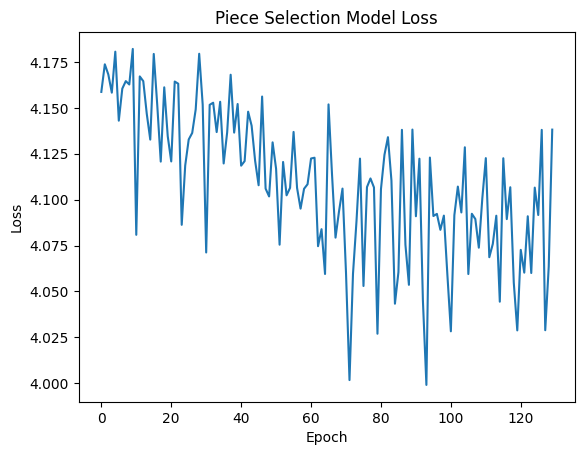

In [21]:
# plot loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Piece Selection Model Loss")
plt.show()

## Evaluation

In [88]:
test_samples_ds = ChessDataset(test_above_1800)
test_samples_dl = DataLoader(test_samples_ds, batch_size=64, shuffle=False)

test_piece_sel_ds = ChessGroupedDataset(grouped_test_samples)
test_piece_sel_dl = DataLoader(test_piece_sel_ds, batch_size=64, shuffle=False)

In [91]:
model.eval()
total = 0
correct = 0
for idx, (x, y) in enumerate(test_samples_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = argmax_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy argmax move: {(correct/total) * 100:.3f}%")

Accuracy: 20.174%


# Training move selection

## Model + training

In [18]:
piece_type = ["p", "n", "b", "r", "q", "k"]  # pawn, knight, bishop, rook, queen, king

In [19]:
src_sample = train_above_1800
move_sel_sample = {piece: filter_by_piece(src_sample, piece) for piece in piece_type}

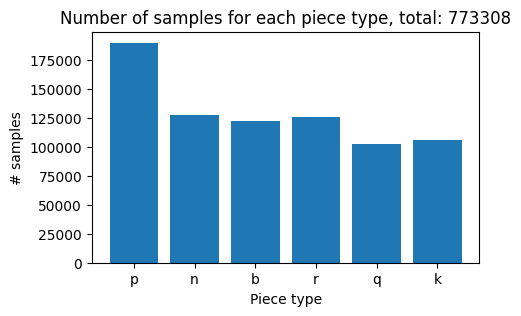

In [20]:
# plot the size of each piece type
plt.figure(figsize=(5, 3))
plt.bar(
    range(len(move_sel_sample)), [len(move_sel_sample[piece]) for piece in piece_type]
)
plt.xticks(range(len(move_sel_sample)), piece_type)
plt.xlabel("Piece type")
plt.ylabel("# samples")
plt.title(f"Number of samples for each piece type, total: {len(src_sample)}")
plt.show()

## Training on single piece


In [30]:
piece = "q" 
lr = 0.002

In [31]:
samples = filter_by_piece(train_above_1800, piece)
ds = ChessDataset(samples, mask_move=True, add_legal_moves=True)
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)

# sample from the dataset
x, y = ds[0]
x.shape, y.shape, len(ds)

(torch.Size([14, 8, 8]), torch.Size([64]), 102251)

In [32]:
model = ChessNet(
    num_classes=64,
    num_channels=14,
    activation=nn.ReLU(inplace=True),
).to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = training(model, dl, criterion, optimizer, num_epochs=10, device=device)

epoch 1/10 | batch 100/1598 | loss: 4.012565376758576 | elap: 4.96s
epoch 1/10 | batch 200/1598 | loss: 3.8893849778175356 | elap: 10.16s
epoch 1/10 | batch 300/1598 | loss: 3.8108711791038514 | elap: 15.11s
epoch 1/10 | batch 400/1598 | loss: 3.788044638633728 | elap: 20.25s
epoch 1/10 | batch 500/1598 | loss: 3.716839394569397 | elap: 25.49s
epoch 1/10 | batch 600/1598 | loss: 3.687727298736572 | elap: 30.61s
epoch 1/10 | batch 700/1598 | loss: 3.6173749494552614 | elap: 35.72s
epoch 1/10 | batch 800/1598 | loss: 3.5763724517822264 | elap: 40.70s
epoch 1/10 | batch 900/1598 | loss: 3.571012468338013 | elap: 45.96s
epoch 1/10 | batch 1000/1598 | loss: 3.4953708267211914 | elap: 50.90s
epoch 1/10 | batch 1100/1598 | loss: 3.4753871512413026 | elap: 55.97s
epoch 1/10 | batch 1200/1598 | loss: 3.4214609932899473 | elap: 61.16s
epoch 1/10 | batch 1300/1598 | loss: 3.386550488471985 | elap: 66.06s
epoch 1/10 | batch 1400/1598 | loss: 3.37542040348053 | elap: 71.04s
epoch 1/10 | batch 1500/

In [34]:
# save the model
torch.save(model.state_dict(), f"{piece}_channel14_relu_epc10_batsize64_lr{lr}.pth")

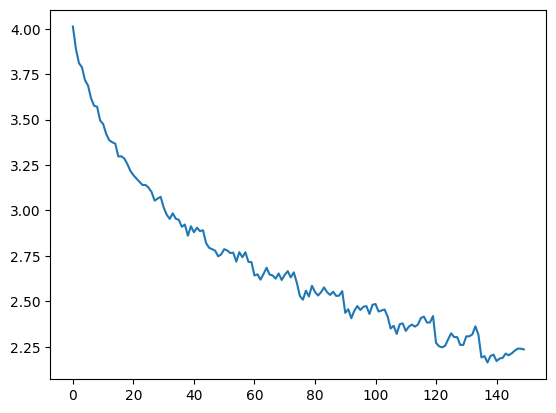

In [35]:
# plot loss history
plt.plot(loss_history)

## Evaluation

In [44]:
# load the model
piece = "p"
model = ChessNet(
    num_classes=64,
    num_channels=7,
    activation=nn.LeakyReLU(inplace=True, negative_slope=0.05),
).to(device)

model.load_state_dict(
    torch.load(
        f"checkpoint/move_selection/move_{piece}_leakyrelu0.05_epc10_batsize128.pth"
    )
)

<All keys matched successfully>

In [36]:
test_samples = filter_by_piece(test_above_1800, piece)
test_ds = ChessDataset(test_samples, mask_move=True, add_legal_moves=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

# sample from the dataset
x, y = test_ds[0]
x.shape, y.shape, len(ds)

(torch.Size([14, 8, 8]), torch.Size([64]), 102251)

In [37]:
model.eval()
total = 0
correct = 0

for idx, (x, y) in enumerate(tqdm(test_dl)):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = argmax_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy argmax move: {(correct/total) * 100:.3f}%")

100%|██████████| 402/402 [00:18<00:00, 21.30it/s]

Accuracy argmax move: 45.066%


# Results

Piece selection(70 epochs, batch size 256): 43.996%

Move selection(10 epochs, batch size 128)
* Pawn: 89.047%
* Knight: 73% 
* Rook: 56.261% - 57.752%
* Bishop: 66.328%
* Queen: 43.269% - 45.054% - 46.778%
* King: 68.859%
